Before diving into implementing Backward propagation trought time, I decided to implement first backward propagation and then go to the step where we can implement it thought time.

I will be using [this](https://blog.zhaytam.com/2018/08/15/implement-neural-network-backpropagation/) tutorial and the any other ressource I will find on the internet.

In [1]:
import numpy as np
np.random.seed(100)

In [2]:
class Layer:
    """
    represent a layer of our neural network
    """
    
    def __init__(self, n_input, neurons, weights=None, biais=None, activation=None):
        """
        n_input : the numbers of input we pass to our network
        neurons : the numbers of neurons in this layer
        weights : the layer weights
        biais   : the layer bias
        
        """
        self.weights = weights if weights else np.random.rand(n_input, neurons)
        self.biais = biais if biais else np.random.rand(neurons)
        self.activation = activation

In [3]:
hidden_layer_1 = Layer(3, 4)

In [4]:
hidden_layer_1.weights.dtype

dtype('float64')

In [5]:
hidden_layer_1.biais

array([0.18532822, 0.10837689, 0.21969749, 0.97862378])

####  Activation

Apply the following activation function to the code :

$\sigma(X*W +B)$

In [6]:
def activate(self, x):
    z = np.dot(x, self.weights) + self.biais
    self.last_activation = self._apply_activation(z)
    return self.last_activation

In [7]:
Layer.activate = activate

In [8]:
def _apply_activation(self, normal):
    """
    apply the activation function to the value pass in parameter
    """
    if self.activation is None:
        return normal
    elif self.activation == 'tanh':
        return np.tanh(normal)
    elif self.activation == 'sigmoid':
        return 1 / (1 + np.exp(normal))
    ### what happen to relu?
    return normal
    

In [9]:
Layer._apply_activation = _apply_activation

In [10]:
hidden_layer_1.activate(np.array([1, 2, 3]))

array([1.14829064, 2.35516451, 4.65967912, 4.10271179])

Let us add our layers to our network and build it

In [11]:
class NeuralNetwork:
    """
    represent a neural network
    """
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        """
        add a layer to the network
        layer : the layer to add to the network
        """
        self.layers.append(layer)
    
    def feed_foward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X
    
    def predict(self, X):
        """
        predict a class or class for multi ouput
        """
        
        outputs = self.feed_foward(X)
        
        if outputs.ndim == 1:
            return np.argmax(outputs)
        return np.argmax(outputs, axis=1)

In [12]:
the_network = NeuralNetwork()

In [13]:
the_network.add_layer(Layer(2, 3, activation='tanh'))
the_network.add_layer(Layer(3, 3, activation='sigmoid'))
the_network.add_layer(Layer(3, 2, activation='sigmoid'))

Let try to see how our network predict a binary operation

In [14]:
the_network.predict(np.array([[0, 0], [0, 1], [1, 0], [1, 1]]))

array([0, 0, 0, 0])

In [15]:
hidden_layer_1.weights.shape

(3, 4)

In [16]:
np.array([[1, 2, 3]])

array([[1, 2, 3]])

In [17]:
np.dot(np.array([[1, 2, 3]]), hidden_layer_1.weights)

array([[0.96296242, 2.24678761, 4.43998162, 3.12408801]])

### Training Phase and Backward Propagation

Let define a function that calculated sigmoid derivate

In [18]:
def apply_activation_derivative(self, r):
    """
    Applies the derivative of the activation function (if any).
    :param r: The normal value.
    :return: The "derived" value.
    """

    # We use 'r' directly here because its already activated, the only values that
    # are used in this function are the last activations that were saved.

    if self.activation is None:
        return r

    if self.activation == 'tanh':
        return 1 - r ** 2

    if self.activation == 'sigmoid':
        return r * (1 - r)

    return r

In [19]:
Layer.apply_activation_derivative = apply_activation_derivative

In [20]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

This implementation comes from this book on chapter 2 http://neuralnetworksanddeeplearning.com/chap2.html, for the intution and the algorithms calculation but the implementation comes from the same tutorials.

In [21]:
def back_propagate(self, X, y, learning_rate):
    """
    Performs the backward propagation algorithm and updates the layers weights.
    :param X: The input values.
    :param y: The target values.
    :param float learning_rate: The learning rate (between 0 and 1).
    """
    output = self.feed_foward(X)
    for i in reversed(range(len(self.layers))):
        layer = self.layers[i]
        if layer == self.layers[-1]: # if we are at the output
            error = y - output
            layer.delta = error * layer.apply_activation_derivative(output)
        else :
            next_layer =  self.layers[i+1] # layer i+1
            layer.error = np.dot(next_layer.weights, next_layer.delta)
            layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)
    for i, layer in enumerate(self.layers):
        # we use X is we are at the first layer
        input_to_use = np.atleast_2d(X if i == 0 else self.layers[i - 1].last_activation) # Z
        layer.weights += layer.delta * input_to_use.T * learning_rate

In [22]:
NeuralNetwork.back_propagate = back_propagate

In [23]:
def train(self, X, y, learning_rate, max_epochs):
    """
    Trains the neural network using backpropagation.
    :param X: The input values.
    :param y: The target values.
    :param float learning_rate: The learning rate (between 0 and 1).
    :param int max_epochs: The maximum number of epochs (cycles).
    :return: The list of calculated MSE errors.
    """

    mses = []

    for i in range(max_epochs):
        for j in range(len(X)):
            self.back_propagate(X[j], y[j], learning_rate)
        if i % 10 == 0:
            mse = np.mean(np.square(y - self.feed_foward(X)))
            mses.append(mse)
            print('Epoch: #{}, MSE: {}'.format(i, float(mse)))

    return mses

In [24]:
@staticmethod
def accuracy(y_pred, y_true):
    """
    Calculates the accuracy between the predicted labels and true labels.
    :param y_pred: The predicted labels.
    :param y_true: The true labels.
    :return: The calculated accuracy.
    """
    return (y_pred == y_true).mean()

In [25]:
NeuralNetwork.train = train

In [26]:
NeuralNetwork.accuracy = accuracy

In [27]:
my_network = NeuralNetwork()
my_network.add_layer(Layer(2, 3, activation='tanh'))
my_network.add_layer(Layer(3, 3, activation='sigmoid'))
my_network.add_layer(Layer(3, 2, activation='sigmoid'))

In [28]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [0], [0], [1]])

In [29]:
my_network.predict(X)

array([0, 0, 0, 0])

In [30]:
y.flatten()

array([0, 0, 0, 1])

In [35]:
# Train the neural network
errors = my_network.train(X, y, 0.03, 10000)
accuracy = my_network.accuracy(my_network.predict(X), y.flatten())*100
print('Accuracy: {}'.format(accuracy))

Epoch: #0, MSE: 0.2118633983820331
Epoch: #10, MSE: 0.21186092859309336
Epoch: #20, MSE: 0.21185846340897158
Epoch: #30, MSE: 0.21185600281675743
Epoch: #40, MSE: 0.21185354680358887
Epoch: #50, MSE: 0.21185109535665153
Epoch: #60, MSE: 0.21184864846317925
Epoch: #70, MSE: 0.2118462061104531
Epoch: #80, MSE: 0.21184376828580165
Epoch: #90, MSE: 0.21184133497660057
Epoch: #100, MSE: 0.21183890617027237
Epoch: #110, MSE: 0.21183648185428627
Epoch: #120, MSE: 0.21183406201615806
Epoch: #130, MSE: 0.21183164664344956
Epoch: #140, MSE: 0.21182923572376894
Epoch: #150, MSE: 0.2118268292447699
Epoch: #160, MSE: 0.2118244271941518
Epoch: #170, MSE: 0.21182202955965962
Epoch: #180, MSE: 0.21181963632908335
Epoch: #190, MSE: 0.21181724749025796
Epoch: #200, MSE: 0.21181486303106326
Epoch: #210, MSE: 0.21181248293942365
Epoch: #220, MSE: 0.21181010720330795
Epoch: #230, MSE: 0.21180773581072893
Epoch: #240, MSE: 0.21180536874974354
Epoch: #250, MSE: 0.2118030060084524
Epoch: #260, MSE: 0.21180064

Epoch: #2160, MSE: 0.2114190150849286
Epoch: #2170, MSE: 0.211417304035167
Epoch: #2180, MSE: 0.2114155956357036
Epoch: #2190, MSE: 0.2114138898803595
Epoch: #2200, MSE: 0.21141218676297527
Epoch: #2210, MSE: 0.2114104862774105
Epoch: #2220, MSE: 0.21140878841754374
Epoch: #2230, MSE: 0.2114070931772728
Epoch: #2240, MSE: 0.21140540055051416
Epoch: #2250, MSE: 0.21140371053120338
Epoch: #2260, MSE: 0.21140202311329448
Epoch: #2270, MSE: 0.21140033829076055
Epoch: #2280, MSE: 0.21139865605759295
Epoch: #2290, MSE: 0.211396976407802
Epoch: #2300, MSE: 0.21139529933541615
Epoch: #2310, MSE: 0.21139362483448237
Epoch: #2320, MSE: 0.21139195289906618
Epoch: #2330, MSE: 0.211390283523251
Epoch: #2340, MSE: 0.21138861670113884
Epoch: #2350, MSE: 0.21138695242684957
Epoch: #2360, MSE: 0.21138529069452125
Epoch: #2370, MSE: 0.2113836314983099
Epoch: #2380, MSE: 0.21138197483238946
Epoch: #2390, MSE: 0.21138032069095178
Epoch: #2400, MSE: 0.21137866906820635
Epoch: #2410, MSE: 0.2113770199583806

Epoch: #4290, MSE: 0.21110596637089069
Epoch: #4300, MSE: 0.21110470564383602
Epoch: #4310, MSE: 0.21110344658993568
Epoch: #4320, MSE: 0.21110218920584645
Epoch: #4330, MSE: 0.21110093348823375
Epoch: #4340, MSE: 0.21109967943377192
Epoch: #4350, MSE: 0.2110984270391443
Epoch: #4360, MSE: 0.21109717630104294
Epoch: #4370, MSE: 0.21109592721616863
Epoch: #4380, MSE: 0.21109467978123103
Epoch: #4390, MSE: 0.21109343399294872
Epoch: #4400, MSE: 0.21109218984804856
Epoch: #4410, MSE: 0.21109094734326647
Epoch: #4420, MSE: 0.21108970647534692
Epoch: #4430, MSE: 0.21108846724104285
Epoch: #4440, MSE: 0.2110872296371161
Epoch: #4450, MSE: 0.21108599366033678
Epoch: #4460, MSE: 0.21108475930748377
Epoch: #4470, MSE: 0.21108352657534435
Epoch: #4480, MSE: 0.21108229546071425
Epoch: #4490, MSE: 0.2110810659603978
Epoch: #4500, MSE: 0.21107983807120767
Epoch: #4510, MSE: 0.21107861178996482
Epoch: #4520, MSE: 0.2110773871134988
Epoch: #4530, MSE: 0.21107616403864743
Epoch: #4540, MSE: 0.21107494

Epoch: #6410, MSE: 0.2108715202117688
Epoch: #6420, MSE: 0.21087055129487514
Epoch: #6430, MSE: 0.2108695835034009
Epoch: #6440, MSE: 0.21086861683537755
Epoch: #6450, MSE: 0.2108676512888411
Epoch: #6460, MSE: 0.21086668686183238
Epoch: #6470, MSE: 0.21086572355239658
Epoch: #6480, MSE: 0.21086476135858342
Epoch: #6490, MSE: 0.21086380027844742
Epoch: #6500, MSE: 0.21086284031004734
Epoch: #6510, MSE: 0.21086188145144663
Epoch: #6520, MSE: 0.2108609237007132
Epoch: #6530, MSE: 0.21085996705591942
Epoch: #6540, MSE: 0.2108590115151422
Epoch: #6550, MSE: 0.21085805707646293
Epoch: #6560, MSE: 0.21085710373796734
Epoch: #6570, MSE: 0.21085615149774573
Epoch: #6580, MSE: 0.21085520035389277
Epoch: #6590, MSE: 0.21085425030450747
Epoch: #6600, MSE: 0.2108533013476934
Epoch: #6610, MSE: 0.21085235348155845
Epoch: #6620, MSE: 0.21085140670421476
Epoch: #6630, MSE: 0.21085046101377908
Epoch: #6640, MSE: 0.2108495164083723
Epoch: #6650, MSE: 0.21084857288611975
Epoch: #6660, MSE: 0.21084763044

Epoch: #9030, MSE: 0.21065107680359202
Epoch: #9040, MSE: 0.21065034688733197
Epoch: #9050, MSE: 0.21064961770561708
Epoch: #9060, MSE: 0.2106488892573342
Epoch: #9070, MSE: 0.21064816154137236
Epoch: #9080, MSE: 0.21064743455662302
Epoch: #9090, MSE: 0.21064670830197973
Epoch: #9100, MSE: 0.21064598277633834
Epoch: #9110, MSE: 0.21064525797859696
Epoch: #9120, MSE: 0.2106445339076559
Epoch: #9130, MSE: 0.21064381056241763
Epoch: #9140, MSE: 0.21064308794178688
Epoch: #9150, MSE: 0.21064236604467068
Epoch: #9160, MSE: 0.2106416448699781
Epoch: #9170, MSE: 0.21064092441662055
Epoch: #9180, MSE: 0.2106402046835115
Epoch: #9190, MSE: 0.2106394856695667
Epoch: #9200, MSE: 0.21063876737370404
Epoch: #9210, MSE: 0.21063804979484368
Epoch: #9220, MSE: 0.21063733293190776
Epoch: #9230, MSE: 0.21063661678382067
Epoch: #9240, MSE: 0.21063590134950913
Epoch: #9250, MSE: 0.21063518662790176
Epoch: #9260, MSE: 0.21063447261792947
Epoch: #9270, MSE: 0.2106337593185252
Epoch: #9280, MSE: 0.2106330467

In [36]:
import matplotlib.pyplot as plt

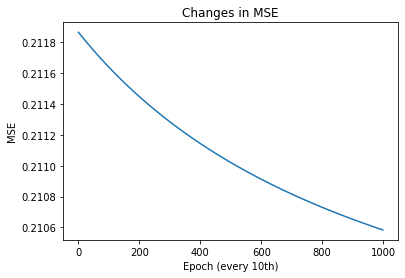

In [37]:
# Plot changes in mse
plt.plot(errors)
plt.title('Changes in MSE')
plt.xlabel('Epoch (every 10th)')
plt.ylabel('MSE')
plt.show()

At least the code is decrasing , should I go back to bbptrough time now?

It's decreasing but not very well